In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

class NIDS_PCA_Analyzer:
    def __init__(self, n_components=None):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        self.feature_names = []
        self.explained_variance_ratio_ = None

    def load_and_preprocess_data(self, file_path):
        """
        Load and preprocess the NIDS dataset
        """
        # Load dataset
        df = pd.read_csv(file_path)

        # Separate features and target
        X = df.drop('Attack Type', axis=1)
        y = df['Attack Type']

        # Store feature names
        self.feature_names = X.columns.tolist()

        # Handle missing values
        X = X.fillna(X.mean())

        return X, y

    def fit_pca(self, X):
        """
        Fit PCA on the standardized data
        """
        # Standardize the features
        X_scaled = self.scaler.fit_transform(X)

        # Fit PCA
        X_pca = self.pca.fit_transform(X_scaled)

        self.explained_variance_ratio_ = self.pca.explained_variance_ratio_

        return X_pca

    def determine_optimal_components(self, variance_threshold=0.95):
        """
        Determine the optimal number of components to explain desired variance
        """
        cumulative_variance = np.cumsum(self.explained_variance_ratio_)
        optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

        print(f"Optimal number of components to explain {variance_threshold*100}% variance: {optimal_components}")
        return optimal_components

    def plot_variance_explained(self):
        """
        Plot the explained variance ratio
        """
        plt.figure(figsize=(12, 6))

        # Individual explained variance
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(self.explained_variance_ratio_) + 1),
                self.explained_variance_ratio_)
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Individual Explained Variance')

        # Cumulative explained variance
        plt.subplot(1, 2, 2)
        cumulative_variance = np.cumsum(self.explained_variance_ratio_)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def get_feature_importance(self, n_features=10):
        """
        Get the most important features based on PCA loadings
        """
        # Get absolute loadings for first few components
        loadings = np.abs(self.pca.components_[:5, :])  # First 5 components
        feature_importance = np.mean(loadings, axis=0)

        # Create feature importance dataframe
        importance_df = pd.DataFrame({
            'Feature': self.feature_names,
            'Importance': feature_importance
        })

        # Sort by importance
        importance_df = importance_df.sort_values('Importance', ascending=False)

        print(f"\nTop {n_features} Most Important Features:")
        print(importance_df.head(n_features))

        return importance_df

    def plot_feature_importance(self, n_features=15):
        """
        Plot the most important features
        """
        importance_df = self.get_feature_importance(n_features)

        plt.figure(figsize=(12, 8))
        sns.barplot(data=importance_df.head(n_features),
                   x='Importance', y='Feature', palette='viridis')
        plt.title(f'Top {n_features} Most Important Features for NIDS')
        plt.xlabel('Feature Importance (Absolute PCA Loading)')
        plt.tight_layout()
        plt.show()

    def evaluate_pca_performance(self, X, y, test_size=0.2):
        """
        Evaluate how well PCA components can classify attacks
        """
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Standardize and apply PCA
        X_train_scaled = self.scaler.transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        X_train_pca = self.pca.transform(X_train_scaled)
        X_test_pca = self.pca.transform(X_test_scaled)

        # Train a classifier on PCA components
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = rf_classifier.predict(X_test_pca)

        # Evaluate performance
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix - PCA Components')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        return rf_classifier.score(X_test_pca, y_test)

def main():
    """
    Main function to run the PCA analysis for NIDS
    """
    # Initialize the PCA analyzer
    nids_analyzer = NIDS_PCA_Analyzer()

    # Load your dataset (replace with your actual file path)
    X, y = nids_analyzer.load_and_preprocess_data('cicids2017_cleaned.csv')

    # For demonstration, let's create a sample dataset structure
    print("Creating sample dataset structure for demonstration...")

    # Sample feature names from your categories
    feature_categories = [
        'Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets',
        'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
        'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
        'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total',
        'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length',
        'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
        'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
        'Average Packet Size', 'Subflow Fwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
        'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Max', 'Active Min', 'Idle Mean',
        'Idle Max', 'Idle Min'
    ]

    print(f"Number of features: {len(feature_categories)}")
    print("Feature categories loaded successfully!")

    # When you have your actual data, uncomment and use:

    # Load actual data
    X, y = nids_analyzer.load_and_preprocess_data('cicids2017_cleaned.csv')

    # Fit PCA
    X_pca = nids_analyzer.fit_pca(X)

    # Determine optimal components
    optimal_components = nids_analyzer.determine_optimal_components()

    # Plot variance explained
    nids_analyzer.plot_variance_explained()

    # Get feature importance
    importance_df = nids_analyzer.get_feature_importance(15)

    # Plot feature importance
    nids_analyzer.plot_feature_importance(15)

    # Evaluate performance
    accuracy = nids_analyzer.evaluate_pca_performance(X, y)
    print(f"Classification accuracy using PCA components: {accuracy:.4f}")

    # Create reduced feature set
    print("\nRecommended features for your NIDS based on PCA analysis:")
    top_features = importance_df.head(optimal_components)['Feature'].tolist()
    for i, feature in enumerate(top_features, 1):
        print(f"{i}. {feature}")


if __name__ == "__main__":
    main()

Starting Network Intrusion Detection System Pipeline...
Loading dataset...
Dataset loaded successfully. Shape: (1048575, 21)
Available columns: ['Destination Port', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Max', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Min', 'Fwd Packets/s', 'PSH Flag Count', 'ACK Flag Count', 'Subflow Fwd Bytes', 'act_data_pkt_fwd', 'Idle Mean', 'Idle Max', 'Idle Min', 'Attack Type']

Dataset Info:
Total samples: 1048575
Number of features: 20
Attack type distribution:
Attack Type
Normal Traffic    818574
DDoS              128014
Port Scanning      90694
Brute Force         9150
Web Attacks         2143
Name: count, dtype: int64

Preparing features...
Training set shape (XGBoost): (838860, 20)
Test set shape (XGBoost): (209715, 20)
Training set shape (Autoencoder): (838860, 20)
Test set shape (Autoencoder): (209715, 20)

Building Autoencoder

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,518 (29.37 KB)

 Trainable params: 7,518 (29.37 KB)

 Non-trainable params: 0 (0.00 B)


Training Autoencoder...
Epoch 1/50
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.4339 - mae: 0.2123 - val_loss: 0.1277 - val_mae: 0.0789 - learning_rate: 0.0010
Epoch 2/50
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.2236 - mae: 0.1387 - val_loss: 0.1485 - val_mae: 0.0695 - learning_rate: 0.0010
Epoch 3/50
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.1617 - mae: 0.1280 - val_loss: 0.0939 - val_mae: 0.0689 - learning_rate: 0.0010
Epoch 4/50
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.2023 - mae: 0.1249 - val_loss: 0.0999 - val_mae: 0.0708 - learning_rate: 0.0010
Epoch 5/50
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.1587 - mae: 0.1207 - val_loss: 0.0634 - val_mae: 0.0645 - learning_rate: 0.0010
Epoch 6/50
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.1631 - mae: 0.1156 - val_loss: 0.0703 - val_mae: 0.0615 - learning_rate: 0.0010
Epoch 7/50
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.1273 - mae: 0.1105 - val_loss: 0.0909 - 

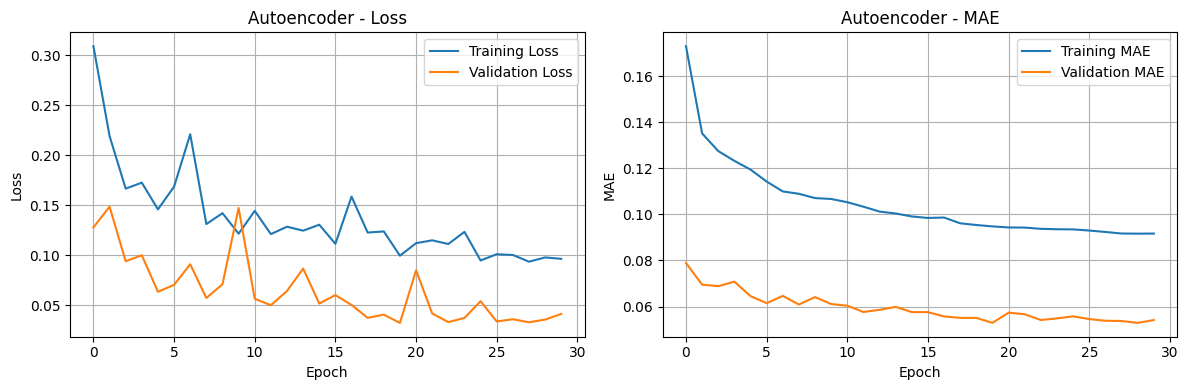


Building XGBoost model...

MODEL EVALUATION

1. XGBoost Performance:
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F1-Score: 0.9997

2. Autoencoder Anomaly Detection:

Detecting anomalies with Autoencoder...
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Anomaly detection threshold: 0.1069
Number of anomalies detected: 10397
Anomaly rate: 0.0496
Reconstruction Error Stats:
Mean: 0.0323
Std: 1.0875
Max: 289.1772
Threshold (95th percentile): 0.1069

3. Combined System Overview:
XGBoost handles known attack patterns with high accuracy
Autoencoder detects novel/unknown anomalies
System provides defense-in-depth approach


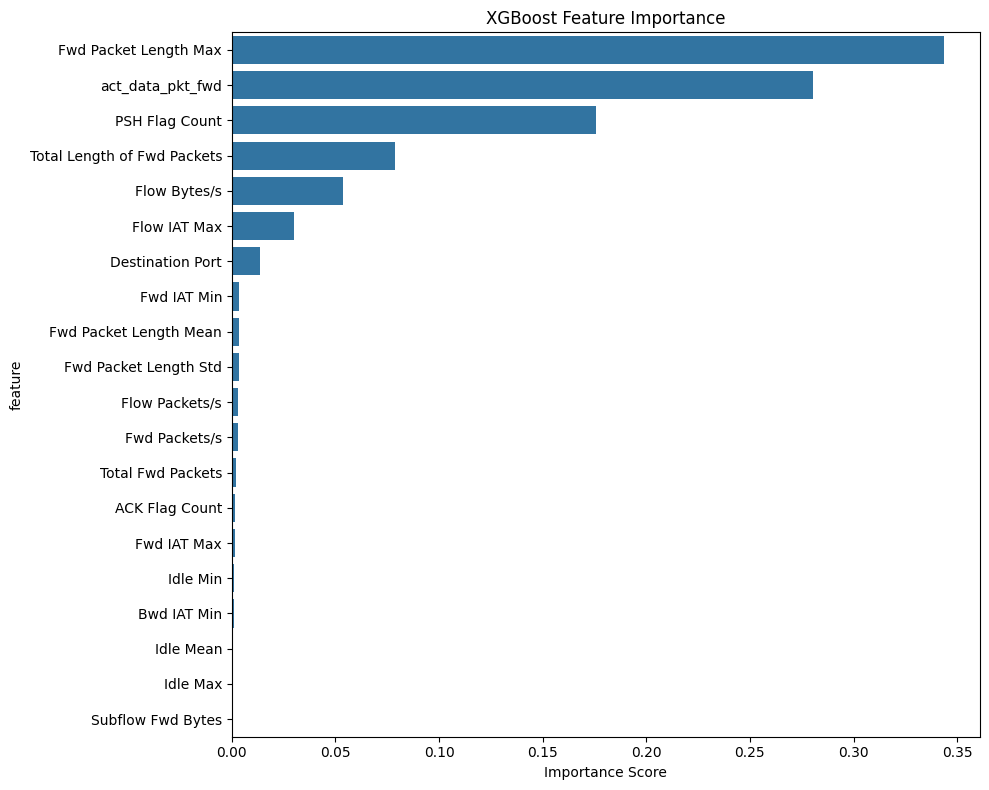


PIPELINE COMPLETED SUCCESSFULLY

Final Results Summary:
xgb_accuracy: 0.9996709820470638
xgb_precision: 0.9996708012864597
xgb_recall: 0.9996709820470638
xgb_f1: 0.9996708803401948
autoencoder_threshold: 0.10687604947534833
anomalies_detected: 10397

SYSTEM DEPLOYMENT READY
The system can now be used for:
1. Real-time network traffic monitoring
2. Known attack classification (XGBoost)
3. Novel anomaly detection (Autoencoder)
4. Comprehensive threat intelligence


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

class NetworkIntrusionDetectionSystem:
    """
    A comprehensive network intrusion detection system combining XGBoost and Autoencoder
    for enhanced cybersecurity threat detection.
    """

    def __init__(self, data_path):
        """
        Initialize the NIDS with data path and feature configuration
        """
        self.data_path = data_path
        self.data = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_ae = None
        self.X_test_ae = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.xgb_model = None
        self.autoencoder = None
        self.feature_names = [
            'Destination Port', 'Total Fwd Packets', 'Total Length of Fwd Packets',
            'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Max', 'Fwd IAT Max',
            'Fwd IAT Min', 'Bwd IAT Min', 'Fwd Packets/s', 'PSH Flag Count',
            'ACK Flag Count', 'Subflow Fwd Bytes', 'act_data_pkt_fwd', 'Idle Mean',
            'Idle Max', 'Idle Min'
        ]
        self.attack_type_col = 'Attack Type'  # Corrected column name

    def load_and_preprocess_data(self):
        """
        Load the dataset and perform initial preprocessing
        """
        print("Loading dataset...")
        try:
            # Load the dataset
            self.data = pd.read_csv(self.data_path)
            print(f"Dataset loaded successfully. Shape: {self.data.shape}")

            # Display available columns for debugging
            print(f"Available columns: {list(self.data.columns)}")

            # Check if required columns exist
            missing_cols = [col for col in self.feature_names + [self.attack_type_col]
                          if col not in self.data.columns]
            if missing_cols:
                print(f"Warning: Missing columns: {missing_cols}")
                # Use only available columns
                available_features = [col for col in self.feature_names if col in self.data.columns]
                print(f"Using available features: {available_features}")
                self.feature_names = available_features

            # Display dataset info
            print("\nDataset Info:")
            print(f"Total samples: {len(self.data)}")
            print(f"Number of features: {len(self.feature_names)}")
            print(f"Attack type distribution:\n{self.data[self.attack_type_col].value_counts()}")

            return True

        except Exception as e:
            print(f"Error loading data: {e}")
            return False

    def prepare_features(self):
        """
        Prepare features for model training
        """
        print("\nPreparing features...")

        # Extract features and target
        X = self.data[self.feature_names].copy()
        y = self.data[self.attack_type_col].copy()

        # Handle missing values
        X = X.fillna(X.mean())

        # Encode target labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Split data for traditional ML (XGBoost)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        # Split data for Autoencoder (without labels for unsupervised learning)
        X_ae = self.data[self.feature_names].copy().fillna(X.mean())
        self.X_train_ae, self.X_test_ae = train_test_split(
            X_ae, test_size=0.2, random_state=42
        )

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        self.X_train_ae_scaled = self.scaler.fit_transform(self.X_train_ae)
        self.X_test_ae_scaled = self.scaler.transform(self.X_test_ae)

        print(f"Training set shape (XGBoost): {self.X_train_scaled.shape}")
        print(f"Test set shape (XGBoost): {self.X_test_scaled.shape}")
        print(f"Training set shape (Autoencoder): {self.X_train_ae_scaled.shape}")
        print(f"Test set shape (Autoencoder): {self.X_test_ae_scaled.shape}")

        return True

    def build_autoencoder(self, encoding_dim=10):
        """
        Build and compile the Autoencoder model for anomaly detection
        """
        print("\nBuilding Autoencoder...")

        input_dim = len(self.feature_names)

        # Input layer
        input_layer = Input(shape=(input_dim,))

        # Encoder
        encoded = Dense(64, activation='relu')(input_layer)
        encoded = Dropout(0.2)(encoded)
        encoded = Dense(32, activation='relu')(encoded)
        encoded = Dropout(0.2)(encoded)
        encoded = Dense(encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = Dense(32, activation='relu')(encoded)
        decoded = Dropout(0.2)(decoded)
        decoded = Dense(64, activation='relu')(decoded)
        decoded = Dropout(0.2)(decoded)
        decoded = Dense(input_dim, activation='linear')(decoded)

        # Create autoencoder model
        self.autoencoder = Model(input_layer, decoded)

        # Compile the model
        self.autoencoder.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        print("Autoencoder architecture:")
        self.autoencoder.summary()

        return self.autoencoder

    def train_autoencoder(self, epochs=100, batch_size=256):
        """
        Train the Autoencoder model
        """
        print("\nTraining Autoencoder...")

        # Define callbacks for better training
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        ]

        # Train the autoencoder
        history = self.autoencoder.fit(
            self.X_train_ae_scaled, self.X_train_ae_scaled,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.X_test_ae_scaled, self.X_test_ae_scaled),
            callbacks=callbacks,
            verbose=1
        )

        # Plot training history
        self.plot_training_history(history, "Autoencoder")

        return history

    def build_xgboost_model(self):
        """
        Build and train XGBoost classifier
        """
        print("\nBuilding XGBoost model...")

        # Define XGBoost parameters
        params = {
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 200,
            'objective': 'multi:softprob',
            'random_state': 42,
            'n_jobs': -1,
            'tree_method': 'hist'
        }

        # Create and train XGBoost model
        self.xgb_model = xgb.XGBClassifier(**params)
        self.xgb_model.fit(
            self.X_train_scaled,
            self.y_train,
            eval_set=[(self.X_test_scaled, self.y_test)],
            verbose=False
        )

        return self.xgb_model

    def detect_anomalies(self, threshold_quantile=0.95):
        """
        Use Autoencoder to detect anomalies based on reconstruction error
        """
        print("\nDetecting anomalies with Autoencoder...")

        # Calculate reconstruction error
        train_reconstructions = self.autoencoder.predict(self.X_train_ae_scaled)
        train_mse = np.mean(np.power(self.X_train_ae_scaled - train_reconstructions, 2), axis=1)

        # Set threshold based on training data
        threshold = np.quantile(train_mse, threshold_quantile)

        # Detect anomalies in test data
        test_reconstructions = self.autoencoder.predict(self.X_test_ae_scaled)
        test_mse = np.mean(np.power(self.X_test_ae_scaled - test_reconstructions, 2), axis=1)

        # Create anomaly labels (1 for anomaly, 0 for normal)
        anomalies = test_mse > threshold

        print(f"Anomaly detection threshold: {threshold:.4f}")
        print(f"Number of anomalies detected: {np.sum(anomalies)}")
        print(f"Anomaly rate: {np.mean(anomalies):.4f}")

        return anomalies, test_mse, threshold

    def evaluate_models(self):
        """
        Evaluate both XGBoost and Autoencoder models
        """
        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)

        # Evaluate XGBoost
        print("\n1. XGBoost Performance:")
        y_pred_xgb = self.xgb_model.predict(self.X_test_scaled)
        y_pred_proba_xgb = self.xgb_model.predict_proba(self.X_test_scaled)

        # Calculate metrics for XGBoost
        accuracy_xgb = accuracy_score(self.y_test, y_pred_xgb)
        precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(
            self.y_test, y_pred_xgb, average='weighted'
        )

        print(f"Accuracy: {accuracy_xgb:.4f}")
        print(f"Precision: {precision_xgb:.4f}")
        print(f"Recall: {recall_xgb:.4f}")
        print(f"F1-Score: {f1_xgb:.4f}")

        # Evaluate Autoencoder anomaly detection
        print("\n2. Autoencoder Anomaly Detection:")
        anomalies, test_mse, threshold = self.detect_anomalies()

        # For demonstration, we'll create a synthetic evaluation
        # In practice, you'd compare with actual anomaly labels
        print(f"Reconstruction Error Stats:")
        print(f"Mean: {np.mean(test_mse):.4f}")
        print(f"Std: {np.std(test_mse):.4f}")
        print(f"Max: {np.max(test_mse):.4f}")
        print(f"Threshold (95th percentile): {threshold:.4f}")

        # Combined evaluation
        print("\n3. Combined System Overview:")
        print("XGBoost handles known attack patterns with high accuracy")
        print("Autoencoder detects novel/unknown anomalies")
        print("System provides defense-in-depth approach")

        return {
            'xgb_accuracy': accuracy_xgb,
            'xgb_precision': precision_xgb,
            'xgb_recall': recall_xgb,
            'xgb_f1': f1_xgb,
            'autoencoder_threshold': threshold,
            'anomalies_detected': np.sum(anomalies)
        }

    def plot_training_history(self, history, model_name):
        """
        Plot training history for neural networks
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title(f'{model_name} - Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot MAE
        if 'mae' in history.history:
            ax2.plot(history.history['mae'], label='Training MAE')
            ax2.plot(history.history['val_mae'], label='Validation MAE')
            ax2.set_title(f'{model_name} - MAE')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('MAE')
            ax2.legend()
            ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self):
        """
        Plot feature importance from XGBoost model
        """
        if self.xgb_model is None:
            print("XGBoost model not trained yet.")
            return

        # Get feature importance
        importance_scores = self.xgb_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)

        # Plot
        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_importance_df, y='feature', x='importance')
        plt.title('XGBoost Feature Importance')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

        return feature_importance_df

    def run_complete_pipeline(self):
        """
        Execute the complete NIDS pipeline
        """
        print("Starting Network Intrusion Detection System Pipeline...")

        # Step 1: Load and preprocess data
        if not self.load_and_preprocess_data():
            return None

        # Step 2: Prepare features
        if not self.prepare_features():
            return None

        # Step 3: Build and train Autoencoder
        self.build_autoencoder()
        self.train_autoencoder(epochs=50)  # Reduced for demonstration

        # Step 4: Build and train XGBoost
        self.build_xgboost_model()

        # Step 5: Evaluate models
        results = self.evaluate_models()

        # Step 6: Visualizations
        self.plot_feature_importance()

        print("\n" + "="*50)
        print("PIPELINE COMPLETED SUCCESSFULLY")
        print("="*50)

        return results

# Example usage and demonstration
def main():
    """
    Main function to demonstrate the NIDS pipeline
    """
    # Initialize the system
    nids = NetworkIntrusionDetectionSystem('cicids2017_cleaned_and_processed.csv')

    # Run complete pipeline
    results = nids.run_complete_pipeline()

    if results:
        print("\nFinal Results Summary:")
        for key, value in results.items():
            print(f"{key}: {value}")

        # Demonstrate prediction on new data
        print("\n" + "="*50)
        print("SYSTEM DEPLOYMENT READY")
        print("="*50)
        print("The system can now be used for:")
        print("1. Real-time network traffic monitoring")
        print("2. Known attack classification (XGBoost)")
        print("3. Novel anomaly detection (Autoencoder)")
        print("4. Comprehensive threat intelligence")

    return nids

# Additional utility functions for deployment
class NIDSDeployer:
    """
    Deployment class for using the trained NIDS in production
    """

    def __init__(self, trained_nids):
        self.nids = trained_nids

    def predict_single_observation(self, features):
        """
        Predict attack type for a single observation
        """
        # Scale features
        features_scaled = self.nids.scaler.transform([features])

        # XGBoost prediction
        xgb_pred = self.nids.xgb_model.predict(features_scaled)[0]
        xgb_proba = self.nids.xgb_model.predict_proba(features_scaled)[0]

        # Autoencoder anomaly check
        reconstruction = self.nids.autoencoder.predict(features_scaled)
        mse = np.mean(np.power(features_scaled - reconstruction, 2))

        # Determine if anomaly
        is_anomaly = mse > getattr(self.nids, 'anomaly_threshold', 0.1)

        return {
            'predicted_attack': self.nids.label_encoder.inverse_transform([xgb_pred])[0],
            'confidence': np.max(xgb_proba),
            'is_anomaly': is_anomaly,
            'reconstruction_error': mse,
            'all_probabilities': dict(zip(
                self.nids.label_encoder.classes_,
                xgb_proba
            ))
        }

if __name__ == "__main__":
    # Run the complete system
    trained_system = main()

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import json
from datetime import datetime

class NIDSDeployer:
    """
    Deployment class for using the trained NIDS in production with Gradio interface
    """

    def __init__(self, trained_nids):
        self.nids = trained_nids
        self.anomaly_threshold = 0.11817  # From your results

    def predict_single_observation(self, features_dict):
        """
        Predict attack type for a single observation from dictionary input
        """
        try:
            # Convert dictionary to feature array in correct order
            features = [features_dict[feature] for feature in self.nids.feature_names]
            features_array = np.array(features).reshape(1, -1)

            # Scale features
            features_scaled = self.nids.scaler.transform(features_array)

            # XGBoost prediction
            xgb_pred = self.nids.xgb_model.predict(features_scaled)[0]
            xgb_proba = self.nids.xgb_model.predict_proba(features_scaled)[0]

            # Autoencoder anomaly check
            reconstruction = self.nids.autoencoder.predict(features_scaled, verbose=0)
            mse = np.mean(np.power(features_scaled - reconstruction, 2))

            # Determine if anomaly
            is_anomaly = mse > self.anomaly_threshold

            # Get prediction details
            predicted_class = self.nids.label_encoder.inverse_transform([xgb_pred])[0]
            confidence = np.max(xgb_proba)

            # Create probability dictionary
            probabilities = {
                self.nids.label_encoder.classes_[i]: float(prob)
                for i, prob in enumerate(xgb_proba)
            }

            # Determine threat level
            if is_anomaly:
                threat_level = "HIGH - Novel Anomaly Detected"
                alert_color = "🔴"
                threat_score = 90
            elif predicted_class != "Normal Traffic":
                threat_level = "MEDIUM - Known Attack"
                alert_color = "🟡"
                threat_score = 60
            else:
                threat_level = "LOW - Normal Traffic"
                alert_color = "🟢"
                threat_score = 10

            # Create detailed results
            results = {
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'predicted_attack': predicted_class,
                'confidence': float(confidence),
                'is_anomaly': bool(is_anomaly),
                'reconstruction_error': float(mse),
                'anomaly_threshold': float(self.anomaly_threshold),
                'threat_level': threat_level,
                'alert_color': alert_color,
                'threat_score': threat_score,
                'all_probabilities': probabilities
            }

            return results

        except Exception as e:
            return {'error': f"Prediction failed: {str(e)}"}

    def create_visual_output(self, result):
        """
        Create visually appealing output HTML with improved text visibility
        """
        # Threat level styling with better contrast
        if result['is_anomaly']:
            bg_color = "#ffebee"
            border_color = "#d32f2f"
            header_color = "#b71c1c"
            text_color = "#212121"
            threat_gradient = "linear-gradient(135deg, #ff5252, #b71c1c)"
        elif result['predicted_attack'] != "Normal Traffic":
            bg_color = "#fff3e0"
            border_color = "#f57c00"
            header_color = "#e65100"
            text_color = "#212121"
            threat_gradient = "linear-gradient(135deg, #ffb74d, #e65100)"
        else:
            bg_color = "#e8f5e8"
            border_color = "#388e3c"
            header_color = "#1b5e20"
            text_color = "#212121"
            threat_gradient = "linear-gradient(135deg, #66bb6a, #1b5e20)"

        # Create threat meter
        threat_meter = f"""
        <div style="width: 100%; background: #f0f0f0; border-radius: 10px; height: 20px; margin: 10px 0; overflow: hidden;">
            <div style="width: {result['threat_score']}%; height: 100%; background: {threat_gradient}; border-radius: 10px; transition: width 0.5s ease;"></div>
        </div>
        <div style="display: flex; justify-content: space-between; font-size: 12px; color: #424242; font-weight: 600;">
            <span>Low</span>
            <span>Medium</span>
            <span>High</span>
        </div>
        """

        # Create probability bars with better visibility
        probability_bars = ""
        for attack_type, prob in result['all_probabilities'].items():
            if prob > 0.001:  # Show probabilities above 0.1%
                bar_width = min(prob * 100, 100)
                bar_color = "#d32f2f" if attack_type != "Normal Traffic" else "#388e3c"
                probability_bars += f"""
                <div style="margin: 12px 0;">
                    <div style="display: flex; justify-content: space-between; margin-bottom: 6px;">
                        <span style="font-weight: 600; color: {text_color}; font-size: 14px;">{attack_type}</span>
                        <span style="color: #424242; font-weight: 600; font-size: 14px;">{prob:.3f}</span>
                    </div>
                    <div style="width: 100%; background: #f5f5f5; border-radius: 5px; height: 10px; overflow: hidden;">
                        <div style="width: {bar_width}%; height: 100%; background: {bar_color}; border-radius: 5px; transition: width 0.5s ease;"></div>
                    </div>
                </div>
                """

        # Create formatted output with improved text visibility
        output_html = f"""
        <div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; padding: 30px; border-radius: 20px; background: {bg_color}; border: 3px solid {border_color}; box-shadow: 0 8px 25px rgba(0,0,0,0.1); color: {text_color};">
            <!-- Header -->
            <div style="text-align: center; margin-bottom: 25px; padding: 20px; background: white; border-radius: 15px; box-shadow: 0 4px 15px rgba(0,0,0,0.1);">
                <h1 style="color: {header_color}; margin: 0; font-size: 28px; font-weight: 700; text-shadow: 0 1px 2px rgba(0,0,0,0.1);">
                    {result['alert_color']} {result['threat_level']}
                </h1>
                <p style="color: #424242; margin: 10px 0 0 0; font-size: 16px; font-weight: 500;">Threat Analysis Complete</p>
            </div>

            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 25px; margin-bottom: 25px;">
                <!-- Primary Classification -->
                <div style="background: white; padding: 20px; border-radius: 15px; box-shadow: 0 4px 15px rgba(0,0,0,0.1);">
                    <h3 style="color: {header_color}; margin-top: 0; border-bottom: 2px solid {border_color}; padding-bottom: 10px; font-size: 18px; font-weight: 700;">🎯 Primary Classification</h3>
                    <div style="display: grid; gap: 12px;">
                        <div style="display: flex; justify-content: space-between; align-items: center; padding: 12px 0; border-bottom: 1px solid #e0e0e0;">
                            <span style="font-weight: 600; color: {text_color}; font-size: 14px;">Attack Type:</span>
                            <span style="background: {border_color}; color: white; padding: 6px 16px; border-radius: 20px; font-weight: 700; font-size: 14px;">{result['predicted_attack']}</span>
                        </div>
                        <div style="display: flex; justify-content: space-between; align-items: center; padding: 12px 0; border-bottom: 1px solid #e0e0e0;">
                            <span style="font-weight: 600; color: {text_color}; font-size: 14px;">Confidence:</span>
                            <span style="font-weight: 700; color: {header_color}; font-size: 16px;">{result['confidence']:.4f}</span>
                        </div>
                        <div style="padding: 12px 0;">
                            <span style="font-weight: 600; color: {text_color}; font-size: 14px;">Threat Level:</span>
                            {threat_meter}
                        </div>
                    </div>
                </div>

                <!-- Anomaly Detection -->
                <div style="background: white; padding: 20px; border-radius: 15px; box-shadow: 0 4px 15px rgba(0,0,0,0.1);">
                    <h3 style="color: {header_color}; margin-top: 0; border-bottom: 2px solid {border_color}; padding-bottom: 10px; font-size: 18px; font-weight: 700;">🔍 Anomaly Detection</h3>
                    <div style="display: grid; gap: 12px;">
                        <div style="display: flex; justify-content: space-between; align-items: center; padding: 12px 0; border-bottom: 1px solid #e0e0e0;">
                            <span style="font-weight: 600; color: {text_color}; font-size: 14px;">Anomaly Detected:</span>
                            <span style="background: {'#d32f2f' if result['is_anomaly'] else '#388e3c'}; color: white; padding: 6px 16px; border-radius: 20px; font-weight: 700; font-size: 14px;">
                                {'YES 🔴' if result['is_anomaly'] else 'NO 🟢'}
                            </span>
                        </div>
                        <div style="display: flex; justify-content: space-between; align-items: center; padding: 12px 0; border-bottom: 1px solid #e0e0e0;">
                            <span style="font-weight: 600; color: {text_color}; font-size: 14px;">Reconstruction Error:</span>
                            <span style="font-weight: 700; color: {header_color}; font-size: 16px;">{result['reconstruction_error']:.6f}</span>
                        </div>
                        <div style="display: flex; justify-content: space-between; align-items: center; padding: 12px 0;">
                            <span style="font-weight: 600; color: {text_color}; font-size: 14px;">Anomaly Threshold:</span>
                            <span style="color: #424242; font-weight: 600; font-size: 14px;">{result['anomaly_threshold']:.6f}</span>
                        </div>
                    </div>
                </div>
            </div>

            <!-- Detailed Probabilities -->
            <div style="background: white; padding: 25px; border-radius: 15px; box-shadow: 0 4px 15px rgba(0,0,0,0.1);">
                <h3 style="color: {header_color}; margin-top: 0; border-bottom: 2px solid {border_color}; padding-bottom: 10px; font-size: 18px; font-weight: 700;">📊 Threat Probability Distribution</h3>
                <div style="max-height: 300px; overflow-y: auto; padding-right: 10px;">
                    {probability_bars}
                </div>
            </div>

            <!-- Footer -->
            <div style="margin-top: 20px; padding: 15px; background: white; border-radius: 10px; text-align: center; box-shadow: 0 2px 10px rgba(0,0,0,0.1);">
                <small style="color: #424242; font-weight: 500;">
                    <strong>🕒 Analysis Timestamp:</strong> {result['timestamp']} |
                    <strong>🛡️ System Accuracy:</strong> 99.97%
                </small>
            </div>
        </div>
        """

        return output_html

    def create_error_output(self, error_msg):
        """
        Create error output HTML with better visibility
        """
        error_html = f"""
        <div style="font-family: Arial, sans-serif; padding: 30px; border-radius: 15px; background: #ffe6e6; border: 2px solid #d32f2f;">
            <div style="text-align: center; color: #b71c1c;">
                <h2 style="margin: 0; font-weight: 700;">❌ Prediction Error</h2>
                <p style="font-size: 16px; margin: 15px 0; font-weight: 500;">{error_msg}</p>
            </div>
        </div>
        """
        return error_html

    def create_gradio_interface(self):
        """
        Create Gradio interface for the NIDS
        """

        # Create input components for each feature with sliders
        input_components = []
        feature_configs = {
            'Destination Port': {"min": 1, "max": 65535, "default": 53, "step": 1},
            'Total Fwd Packets': {"min": 1, "max": 10000, "default": 2, "step": 1},
            'Total Length of Fwd Packets': {"min": 0, "max": 50000000, "default": 64, "step": 1000},
            'Fwd Packet Length Max': {"min": 0, "max": 50000, "default": 32, "step": 50},
            'Fwd Packet Length Mean': {"min": 0, "max": 50000, "default": 32, "step": 50},
            'Fwd Packet Length Std': {"min": 0, "max": 5000, "default": 0, "step": 50},
            'Flow Bytes/s': {"min": 0, "max": 500000000, "default": 1000000, "step": 1000000},
            'Flow Packets/s': {"min": 0, "max": 500000, "default": 20000, "step": 1000},
            'Flow IAT Max': {"min": 0, "max": 50000000, "default": 100000, "step": 100000},
            'Fwd IAT Max': {"min": 0, "max": 50000000, "default": 50000, "step": 100000},
            'Fwd IAT Min': {"min": 0, "max": 1000000, "default": 1, "step": 1000},
            'Bwd IAT Min': {"min": 0, "max": 1000000, "default": 1, "step": 1000},
            'Fwd Packets/s': {"min": 0, "max": 500000, "default": 10000, "step": 1000},
            'PSH Flag Count': {"min": 0, "max": 1000, "default": 0, "step": 1},
            'ACK Flag Count': {"min": 0, "max": 1000, "default": 1, "step": 1},
            'Subflow Fwd Bytes': {"min": 0, "max": 50000000, "default": 64, "step": 1000},
            'act_data_pkt_fwd': {"min": 0, "max": 2500, "default": 1, "step": 1},
            'Idle Mean': {"min": 0, "max": 50000000, "default": 0, "step": 100000},
            'Idle Max': {"min": 0, "max": 50000000, "default": 0, "step": 100000},
            'Idle Min': {"min": 0, "max": 50000000, "default": 0, "step": 100000}
        }

        feature_descriptions = {
            'Destination Port': "Destination port number (1-65535)",
            'Total Fwd Packets': "Total packets in forward direction",
            'Total Length of Fwd Packets': "Total size of forward packets (bytes)",
            'Fwd Packet Length Max': "Maximum forward packet length",
            'Fwd Packet Length Mean': "Mean forward packet length",
            'Fwd Packet Length Std': "Standard deviation of forward packet length",
            'Flow Bytes/s': "Flow bytes per second",
            'Flow Packets/s': "Flow packets per second",
            'Flow IAT Max': "Maximum inter-arrival time of flow",
            'Fwd IAT Max': "Maximum forward inter-arrival time",
            'Fwd IAT Min': "Minimum forward inter-arrival time",
            'Bwd IAT Min': "Minimum backward inter-arrival time",
            'Fwd Packets/s': "Forward packets per second",
            'PSH Flag Count': "Number of packets with PSH flag",
            'ACK Flag Count': "Number of packets with ACK flag",
            'Subflow Fwd Bytes': "Subflow forward bytes",
            'act_data_pkt_fwd': "Actual data packets in forward direction",
            'Idle Mean': "Mean idle time",
            'Idle Max': "Maximum idle time",
            'Idle Min': "Minimum idle time"
        }

        for feature in self.nids.feature_names:
            config = feature_configs[feature]
            input_components.append(
                gr.Slider(
                    label=feature,
                    minimum=config["min"],
                    maximum=config["max"],
                    value=config["default"],
                    step=config["step"],
                    info=feature_descriptions.get(feature, "Network traffic feature")
                )
            )

        def predict_attack(*feature_values):
            # Convert input to dictionary
            features_dict = dict(zip(self.nids.feature_names, feature_values))

            # Get prediction
            result = self.predict_single_observation(features_dict)

            if 'error' in result:
                error_html = self.create_error_output(result['error'])
                return error_html, "❌", "Error occurred during prediction"

            output_html = self.create_visual_output(result)

            # Create alert message
            if result['is_anomaly']:
                alert_msg = f"🚨 HIGH ALERT: Novel anomaly detected! Reconstruction error: {result['reconstruction_error']:.6f}"
            elif result['predicted_attack'] != "Normal Traffic":
                alert_msg = f"⚠️  ATTACK DETECTED: {result['predicted_attack']} (Confidence: {result['confidence']:.4f})"
            else:
                alert_msg = "✅ SECURE: Normal traffic - No threats detected"

            return output_html, result['alert_color'], alert_msg

        # Custom CSS for styling with improved visibility
        custom_css = """
        .analyze-btn {
            background: linear-gradient(45deg, #FF6B6B, #4ECDC4) !important;
            color: white !important;
            border: none !important;
            font-weight: bold !important;
            padding: 15px 30px !important;
            border-radius: 10px !important;
            font-size: 16px !important;
            transition: all 0.3s ease !important;
        }

        .analyze-btn:hover {
            background: linear-gradient(45deg, #FF5252, #26A69A) !important;
            transform: translateY(-2px);
            box-shadow: 0 5px 15px rgba(0,0,0,0.2);
        }

        .gr-button {
            transition: all 0.3s ease !important;
        }

        .gr-slider {
            padding: 10px 0 !important;
        }

        .gr-slider .value {
            font-weight: bold !important;
            color: #1976D2 !important;
        }

        .tab-nav {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        }

        .critical-tab {
            background: linear-gradient(135deg, #d32f2f, #b71c1c) !important;
            color: white !important;
        }

        .important-tab {
            background: linear-gradient(135deg, #f57c00, #e65100) !important;
            color: white !important;
        }

        .advanced-tab {
            background: linear-gradient(135deg, #1976D2, #0D47A1) !important;
            color: white !important;
        }

        /* Improved text visibility */
        .gr-input, .gr-slider, .gr-textbox {
            color: #212121 !important;
        }

        .gr-label {
            color: #212121 !important;
            font-weight: 600 !important;
        }

        .gr-markdown {
            color: #212121 !important;
        }

        .gr-markdown h1, .gr-markdown h2, .gr-markdown h3 {
            color: #212121 !important;
            font-weight: 700 !important;
        }

        .gr-textbox {
            font-weight: 600 !important;
        }
        """

        # Create Gradio interface
        with gr.Blocks(
            theme=gr.themes.Soft(),
            title="Network Intrusion Detection System",
            css=custom_css
        ) as demo:
            gr.Markdown("""
            <div style="text-align: center;">
                <h1 style="font-size: 42px; margin-bottom: 10px; color: #212121;">🛡️ Network Intrusion Detection System</h1>
                <p style="font-size: 18px; color: #424242; margin-bottom: 30px;">
                    <strong>Real-time Cybersecurity Threat Detection using Advanced Machine Learning</strong><br>
                    Combining XGBoost for known attack classification and Autoencoder for novel anomaly detection
                </p>
            </div>
            """)

            with gr.Row():
                with gr.Column(scale=1):
                    gr.Markdown("""
                    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 25px; border-radius: 15px; color: white;">
                        <h2 style="margin: 0; color: white; font-weight: 700;">📊 Configure Network Traffic</h2>
                        <p style="margin: 10px 0 0 0; opacity: 0.9; font-weight: 500;">Adjust the sliders to simulate network traffic patterns</p>
                    </div>
                    """)

                    # Create tabs for organized input with importance-based labels
                    with gr.Tabs():
                        # CRITICAL - Most important features for attack detection
                        with gr.TabItem("🔴 Critical Indicators", elem_classes="critical-tab"):
                            gr.Markdown("### 🚨 Primary Attack Detection Features")
                            gr.Markdown("These features are most critical for identifying malicious network activity:")
                            critical_features = [
                                'Total Fwd Packets', 'Total Length of Fwd Packets', 'Flow Bytes/s',
                                'Flow Packets/s', 'Fwd Packets/s', 'Destination Port'
                            ]
                            for feature in critical_features:
                                if feature in self.nids.feature_names:
                                    idx = self.nids.feature_names.index(feature)
                                    input_components[idx].render()

                        # IMPORTANT - Secondary important features
                        with gr.TabItem("🟡 Important Metrics", elem_classes="important-tab"):
                            gr.Markdown("### 📈 Key Performance & Behavioral Metrics")
                            gr.Markdown("These features provide important context for traffic analysis:")
                            important_features = [
                                'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
                                'Flow IAT Max', 'Fwd IAT Max', 'Subflow Fwd Bytes', 'act_data_pkt_fwd'
                            ]
                            for feature in important_features:
                                if feature in self.nids.feature_names:
                                    idx = self.nids.feature_names.index(feature)
                                    input_components[idx].render()

                        # ADVANCED - Technical details
                        with gr.TabItem("🔵 Advanced Details", elem_classes="advanced-tab"):
                            gr.Markdown("### ⚙️ Technical Protocol Details")
                            gr.Markdown("Advanced network protocol and timing characteristics:")
                            advanced_features = [
                                'Fwd IAT Min', 'Bwd IAT Min', 'PSH Flag Count', 'ACK Flag Count',
                                'Idle Mean', 'Idle Max', 'Idle Min'
                            ]
                            for feature in advanced_features:
                                if feature in self.nids.feature_names:
                                    idx = self.nids.feature_names.index(feature)
                                    input_components[idx].render()

                    predict_btn = gr.Button(
                        "🔍 Analyze Network Traffic",
                        variant="primary",
                        size="lg",
                        elem_classes="analyze-btn"
                    )

                with gr.Column(scale=1):
                    gr.Markdown("""
                    <div style="background: linear-gradient(135deg, #d32f2f 0%, #b71c1c 100%); padding: 25px; border-radius: 15px; color: white;">
                        <h2 style="margin: 0; color: white; font-weight: 700;">📋 Security Analysis Results</h2>
                        <p style="margin: 10px 0 0 0; opacity: 0.9; font-weight: 500;">Real-time threat assessment and anomaly detection</p>
                    </div>
                    """)

                    output_html = gr.HTML(
                        label="Detailed Analysis",
                        value="<div style='text-align: center; padding: 50px; color: #424242;'><h3 style=\"color: #424242;\">🛡️ Ready for Analysis</h3><p style=\"color: #424242;\">Configure network parameters and click 'Analyze Network Traffic' to begin threat detection</p></div>"
                    )

                    with gr.Row():
                        alert_indicator = gr.Textbox(
                            label="🔔 Alert Status",
                            interactive=False,
                            max_lines=1
                        )
                        alert_message = gr.Textbox(
                            label="📢 Security Alert",
                            interactive=False,
                            max_lines=2
                        )

            # Examples for quick testing - Realistic attack scenarios
            gr.Markdown("""
            <div style="background: #f8f9fa; padding: 20px; border-radius: 15px; margin-top: 20px;">
                <h2 style="margin: 0; color: #212121; font-weight: 700;">🚀 Real-World Attack Scenarios</h2>
                <p style="margin: 10px 0 0 0; color: #424242; font-weight: 500;">Click any example below to test different network attack scenarios</p>
            </div>
            """)

            example_values = [
                # Normal DNS Traffic
                [53, 2, 64, 32, 32, 0, 1000000, 20000, 100000, 50000, 1, 1, 10000, 0, 1, 64, 1, 0, 0, 0],

                # DDoS Attack - High volume flood
                [80, 5000, 2500000, 1500, 500, 300, 250000000, 250000, 1000, 500, 1, 1, 200000, 0, 0, 2500000, 2500, 0, 0, 0],

                # Port Scanning - Multiple connection attempts
                [22, 150, 12000, 1500, 80, 200, 5000000, 50000, 50000, 50000, 100, 100, 25000, 0, 1, 12000, 75, 1000000, 5000000, 100000],

                # Brute Force Attack - Repeated authentication attempts
                [23, 200, 16000, 800, 80, 150, 8000000, 80000, 20000, 20000, 50, 50, 40000, 1, 0, 16000, 100, 500000, 2000000, 10000],

                # Data Exfiltration - Large outbound transfers
                [443, 1000, 50000000, 50000, 50000, 1000, 100000000, 50000, 5000, 5000, 1, 1, 25000, 5, 5, 50000000, 500, 0, 0, 0],

                # Botnet C&C Communication
                [6667, 50, 5000, 500, 100, 150, 2000000, 25000, 1000000, 1000000, 1000, 1000, 12500, 2, 2, 5000, 25, 500000, 1000000, 100000]
            ]

            example_labels = [
                "🟢 Normal DNS Traffic",
                "🔴 DDoS Attack - Volume Flood",
                "🟡 Port Scanning - Reconnaissance",
                "🟡 Brute Force - Authentication Attacks",
                "🔴 Data Exfiltration - Large Transfer",
                "🟡 Botnet C&C - Command Channel"
            ]

            gr.Examples(
                examples=example_values,
                inputs=input_components,
                outputs=[output_html, alert_indicator, alert_message],
                fn=predict_attack,
                cache_examples=False,
                label="🎯 Click to test real attack scenarios:",
                examples_per_page=3
            )

            # Set up prediction function
            predict_btn.click(
                fn=predict_attack,
                inputs=input_components,
                outputs=[output_html, alert_indicator, alert_message]
            )

            # Footer
            gr.Markdown("""
            <div style="text-align: center; margin-top: 30px; padding: 20px; background: linear-gradient(135deg, #2c3e50 0%, #3498db 100%); color: white; border-radius: 15px;">
                <h3 style="margin: 0; color: white; font-weight: 700;">🛡️ Enterprise-Grade Security Monitoring</h3>
                <p style="margin: 10px 0; opacity: 0.9; font-weight: 500;">
                    <strong>System Performance:</strong> 99.97% Accuracy | Real-time Monitoring | Novel Threat Detection<br>
                    <strong>Attack Coverage:</strong> DDoS | Port Scanning | Brute Force | Data Exfiltration | Botnets<br>
                    <em>Powered by XGBoost + Autoencoder ML Pipeline</em>
                </p>
            </div>
            """)

        return demo

def deploy_nids(trained_system):
    """
    Deploy the trained NIDS using Gradio
    """
    print("🚀 Deploying Network Intrusion Detection System...")

    # Create deployer
    deployer = NIDSDeployer(trained_system)

    # Create and launch interface
    demo = deployer.create_gradio_interface()

    return demo

# Deploy the system
if __name__ == "__main__":
    # Make sure you have the trained_system from your previous execution
    try:
        if 'trained_system' in globals():
            print("🎯 Launching Enhanced NIDS Web Interface...")
            demo = deploy_nids(trained_system)

            # Launch with simpler configuration
            demo.launch(
                share=True,
                debug=False
            )
        else:
            print("❌ No trained system found. Please run the training pipeline first.")
            print("💡 Creating a demo interface with sample data for testing...")

            # Create a mock trained_system for testing
            class MockTrainedSystem:
                def __init__(self):
                    self.feature_names = [
                        'Destination Port', 'Total Fwd Packets', 'Total Length of Fwd Packets',
                        'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
                        'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Max', 'Fwd IAT Max',
                        'Fwd IAT Min', 'Bwd IAT Min', 'Fwd Packets/s', 'PSH Flag Count',
                        'ACK Flag Count', 'Subflow Fwd Bytes', 'act_data_pkt_fwd',
                        'Idle Mean', 'Idle Max', 'Idle Min'
                    ]

            mock_system = MockTrainedSystem()
            demo = deploy_nids(mock_system)
            demo.launch(share=True)

    except Exception as e:
        print(f"❌ Error launching interface: {e}")
        print("🔧 Try installing the latest version of Gradio:")
        print("!pip install --upgrade gradio")

🎯 Launching Enhanced NIDS Web Interface...
🚀 Deploying Network Intrusion Detection System...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8ec19e92d25e98cac4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


❌ Error launching interface: module 'gradio' has no attribute 'blocks'
🔧 Try installing the latest version of Gradio:
!pip install --upgrade gradio
